# Case Study: Analysis of a Double Pipe Heat Exchanger

A stalwart of undergraduate chemical engineering laboratories is study of a double-pipe heat exchanger in counter-current flow. In this case, a student group collected multiple measurements of flow and temperature data from a heat exchanger with sensors configured as shown in the following diagram. (Note: The diagram shows co-current flow. The data was collected with the valves configured for counter-current flow of the hot stream.)

![](https://www.gunt.de/images/datasheet/1495/WL-315C-Comparison-of-various-heat-exchangers-gunt-1495-zeichnung_einzelheit_2.jpg)
Source: [Gunt WL315C Product Description](https://www.gunt.de/en/products/comparison-of-various-heat-exchangers/060.315C0/wl315c/glct-1:pa-148:pr-1495)

## Reading Data

The raw data was copied to a new sheet in the same Google Sheets file, edited to conform with Tidy Data, and a link created using the procedures outlined above for reading data from Google Sheets. The data is read in the following cell.

In [20]:
hx = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSNUCEFMaGZ-y18p-AnDoImEeenMLbRxXBABwFNeP8I3xiUejolPJx-kr4aUywD0szRel81Kftr8J0R/pub?gid=865146464&single=true&output=csv")
hx.head()


,Flow Rate H,Flow Rate C,Trial #,Hot Flow (L/hr),Cold Flow (L/hr),Time,H Outlet,H Inlet,C Inlet,C Outlet
0,H,H,1,651,798,32:08.1,37.3,56.4,15.5,30.8
1,H,H,1,651,798,32:07.8,37.2,56.3,15.4,30.8
2,H,H,1,651,798,32:07.6,37.2,56.3,15.4,30.8
3,H,M,2,650,512,29:13.0,41.4,56.4,15.6,34.7
4,H,M,2,650,512,29:12.3,41.4,56.4,15.6,34.7


## Energy Balances

The first step in this analysis is to verify the energy balance. 

$$
\begin{align*}
Q_h & = \dot{q}_h \rho C_p (T_{h,in} - T_{h,out}) \\
Q_c & = \dot{q}_c \rho C_p (T_{c,out} - T_{c, in})
\end{align*}
$$

The next cell creates two new calculated variables in the dataframe for $Q_h$ and $Q_c$, and uses the pandas plotting facility to visualize the results. This calculation takes advantage of the "one variable per column" rule of Tidy Data which enables calculations for all observations to be done in a single line of code.

,Qh,Qc,Loss (%)
0,14.44,14.18,1.81
1,14.44,14.27,1.17
2,14.44,14.27,1.17
3,11.32,11.35,-0.30
4,11.32,11.35,-0.30
5,11.32,11.35,-0.30
6,6.46,6.11,5.41
7,6.46,6.09,5.77
8,6.46,6.09,5.77
9,12.79,12.55,1.85


<AxesSubplot:xlabel='Observation', ylabel='kW'>

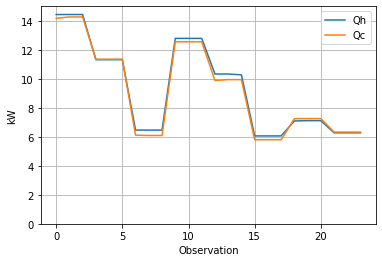

In [21]:
# heat capacity of water 
rho = 1.00                # kg / liter
Cp = 4.18                 # kJ/ kg / deg C

# heat balances
hx["Qh"] = rho * Cp * hx["Hot Flow (L/hr)"] * (hx["H Inlet"] - hx["H Outlet"]) / 3600
hx["Qc"] = rho * Cp * hx["Cold Flow (L/hr)"] * (hx["C Outlet"] - hx["C Inlet"]) / 3600
hx["Loss (%)"] = 100 * (1 - hx["Qc"]/hx["Qh"])

# plot
display(hx[["Qh", "Qc", "Loss (%)"]].style.format(precision=2))
hx.plot(y = ["Qh", "Qc"], ylim = (0, 15), grid=True, xlabel="Observation", ylabel="kW")

## Overall Heat Transfer Coefficient $UA$

The performance of a counter-current heat exchanger is given the relationship

$$Q = U A \Delta T_{lm} $$

where $\Delta T_{lm}$ is the log-mean temperature given by

$$
\begin{align*}
\Delta T_0 & = T_{h, out} - T_{c, in} \\
\Delta T_1 & = T_{h, in} - T_{c, out} \\
\\
\Delta T_{lm} & = \frac{\Delta T_1 - \Delta T_0}{\ln\frac{\Delta T_1}{\Delta T_0}}
\end{align*}
$$

<AxesSubplot:xlabel='Observation', ylabel='kW/deg C'>

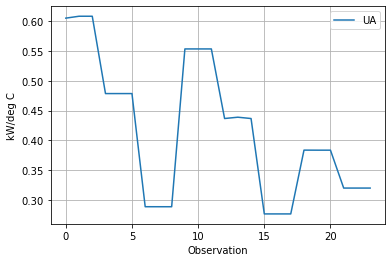

In [31]:
dT0 = hx["H Outlet"] - hx["C Inlet"]
dT1 = hx["H Inlet"] - hx["C Outlet"]
hx["LMTD"] = (dT1 - dT0) / np.log(dT1/dT0)

Q = (hx.Qh + hx.Qc)/2
hx["UA"] =  Q/hx.LMTD

hx.plot(y="UA", xlabel="Observation", ylabel="kW/deg C", grid=True)

## How does $UA$ depend on flowrates?

The data clearly demonstrate that the heat transfer coefficient in the double pipe heat exchanger depends on flowrates of both the cold and hot liquid streams. We can see this by inspecting the data.

In [23]:
hx[["Flow Rate H", "Flow Rate C", "Hot Flow (L/hr)", "Cold Flow (L/hr)", "UA"]]

,Flow Rate H,Flow Rate C,Hot Flow (L/hr),Cold Flow (L/hr),UA
0,H,H,651,798,0.604966
1,H,H,651,798,0.608145
2,H,H,651,798,0.608145
3,H,M,650,512,0.478571
4,H,M,650,512,0.478571
5,H,M,650,512,0.478571
6,H,L,655,201,0.288997
7,H,L,655,201,0.288976
8,H,L,655,201,0.288976
9,M,H,503,795,0.553374


The replicated measurements provide an opportunity to compute averages. Here we use the pandas `.groupby()` function to group observations and compute means. The data will be used to plot results, so we'll save the results of these calculations as a new dataframe for reuse.

In [24]:
sx = hx.groupby(["Flow Rate H", "Flow Rate C"]).mean()[["Hot Flow (L/hr)", "Cold Flow (L/hr)", "UA"]]
sx

Hot Flow (L/hr)  Cold Flow (L/hr)        UA
Flow Rate H Flow Rate C                                             
H           H                      651.0             798.0  0.607085
            L                      655.0             201.0  0.288983
            M                      650.0             512.0  0.478571
L           H                      205.0             801.0  0.383771
            M                      204.0             500.0  0.320247
M           H                      503.0             795.0  0.553374
            L                      502.0             199.0  0.276936
            M                      500.0             498.0  0.437509

Flow Rate H
H    AxesSubplot(0.125,0.125;0.775x0.755)
L    AxesSubplot(0.125,0.125;0.775x0.755)
M    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

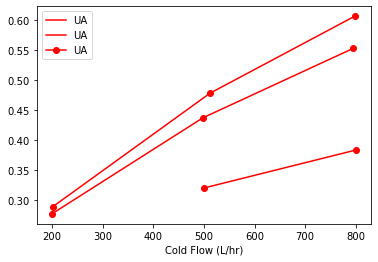

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
sx.sort_values("Cold Flow (L/hr)").groupby("Flow Rate H").plot(x = "Cold Flow (L/hr)", y = "UA", 
                                                               style={"UA": 'ro-'}, ax=ax)

Flow Rate C
H    AxesSubplot(0.125,0.125;0.775x0.755)
L    AxesSubplot(0.125,0.125;0.775x0.755)
M    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

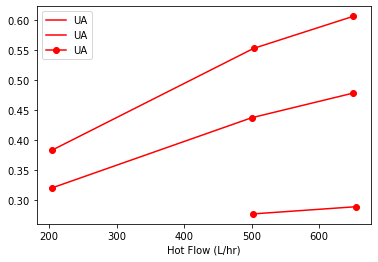

In [26]:
fig, ax = plt.subplots(1, 1)
sx.sort_values("Hot Flow (L/hr)").groupby("Flow Rate C").plot(x = "Hot Flow (L/hr)", y = "UA", 
                                                               style={"UA": 'ro-'}, ax=ax)

## Fitting a Model for $UA$

For a series of transport mechanisms, the overall heat transfer coefficient 

$$\frac{1}{UA} = \frac{1}{U_hA} + \frac{1}{U_{tubeA}} + \frac{1}{U_cA}$$

$U_{tube}A$ is a constant for this experiment. $U_h$A and $U_c$A varying with flowrate and proporitonal to dimensionless Nusselt number.  The hot and cold liquid flows in the double pipe heat exchanger are well within the range for fully developed turbulent flow. Under these conditions for flows inside closed tubes, the Dittus-Boelter equation provides an explicit expression for Nusselt number

$$Nu = C \cdot Re ^{4/5} Pr ^ n$$

where $C$ is a constant, $Re$ is the Reynold's number that is proportional to flowrate, and $Pr$ is the Prandtl number determined by fluid properties.

Experimentally, consider a set of values for $UA$ determined by varying $\dot{m}_h$ and $\dot{m}_c$ over range of values. Because Reynold's number is proportional to flowrate, we can propose a model

$$\frac{1}{UA} = R =  R_{t} + r_h \dot{q}_h^{-0.8} + r_c \dot{q}_h^{-0.8}$$

This suggests a linear regression for $R = \frac{1}{UA}$ in terms of $X_h = \dot{q}_h^{-0.8}$ and $X_c  = \dot{q}_c^{-0.8}$.


In [27]:
hx["R"] = 1.0/hx["UA"]
hx["Xh"] = hx["Hot Flow (L/hr)"]**(-0.8)
hx["Xc"] = hx["Cold Flow (L/hr)"]**(-0.8)

In [28]:
import statsmodels.formula.api as sm

result = sm.ols(formula="R ~ Xh + Xc", data = hx).fit()
print(result.params)
print(result.summary())

Intercept      0.141716
Xh           115.292199
Xc           186.346764
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3711.
Date:                Tue, 01 Feb 2022   Prob (F-statistic):           1.70e-27
Time:                        08:53:59   Log-Likelihood:                 44.929
No. Observations:                  24   AIC:                            -83.86
Df Residuals:                      21   BIC:                            -80.32
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

In [29]:
hx["Rh"] = 115.3 * hx["Xh"]
hx["Rc"] = 186.3 * hx["Xc"]
hx["Rt"] = 0.142

hx["R_pred"] = hx["Rt"] + hx["Rh"] + hx["Rc"]
hx[["R", "R_pred", "Rt", "Rh", "Rc"]]

,R,R_pred,Rt,Rh,Rc
0,1.652986,1.677494,0.142,0.647090,0.888404
1,1.644344,1.677494,0.142,0.647090,0.888404
2,1.644344,1.677494,0.142,0.647090,0.888404
3,2.089553,2.056945,0.142,0.647886,1.267059
4,2.089553,2.056945,0.142,0.647886,1.267059
5,2.089553,2.056945,0.142,0.647886,1.267059
6,3.460242,3.462974,0.142,0.643926,2.677047
7,3.460489,3.462974,0.142,0.643926,2.677047
8,3.460489,3.462974,0.142,0.643926,2.677047
9,1.807095,1.828466,0.142,0.795380,0.891085


## Comparison of Model to Experimental Data

<AxesSubplot:title={'center':'Heat Transfer Coefficient'}>

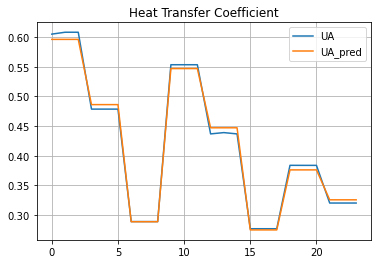

In [30]:
hx["UA_pred"] = 1/hx["R_pred"]
hx.plot(y = ["UA", "UA_pred"], grid=True, title="Heat Transfer Coefficient")